## WIFI Logs analysis

Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'


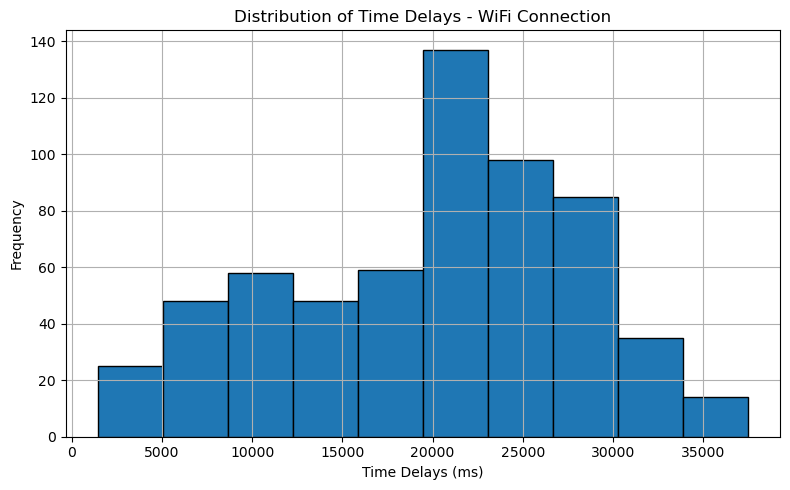


Characteristic Values:
+------------------+------------------+-------------------+----------------------+---------------------+
|   Min Delay (ms) |   Max Delay (ms) |   Mean Delay (ms) |   Std Deviation (ms) |   Median Delay (ms) |
+==================+==================+===================+======================+=====================+
|             1461 |            37469 |           19874.7 |              8033.25 |               20803 |
+------------------+------------------+-------------------+----------------------+---------------------+

Sample of 10 Requests and Delays:
+---------------+--------------+--------------------+
|    Request ID |   Delay (ms) |   Normalized Delay |
+===============+==============+====================+
| 9674488783295 |      20063.3 |           0.516617 |
+---------------+--------------+--------------------+
| 3261361472865 |      20050.7 |           0.516265 |
+---------------+--------------+--------------------+
| 1656169256561 |      20384   |      

In [63]:
import re
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate  # NEW: to make tables Word-friendly

# Define the path to the log file
log_file_path = './data/parity-trials-exp-wifi-cleaned.log'

# Read logs from the file
with open(log_file_path, 'r') as file:
    logs = file.readlines()

delays = []
labels = []

for line in logs:
    if 'request:' in line:
        # Extract the log timestamp
        log_time_match = re.search(r'INFO \d{4}-\d{2}-\d{2} \d{2}:\d{2}:(\d{2},\d{3})', line)
        if not log_time_match:
            continue
        log_seconds, log_milliseconds = map(int, log_time_match.group(1).replace(',', '.').split('.'))
        
        # Extract the JSON and parse it
        json_part = line.split('request: ')[1]
        
        try:
            # Fix single quotes for json.loads
            json_part = json_part.replace("'", '"')
            data = json.loads(json_part)
            
            # Extract the timestamp inside meterValue
            timestamp_str = data[3]['meterValue'][0]['timestamp']
            request_id = data[1]  # request ID for labeling
            ts = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S.%fZ")
            json_seconds = ts.second
            json_milliseconds = ts.microsecond // 1000
            
            # Calculate delay in milliseconds
            delay_ms = (log_seconds * 1000 + log_milliseconds) - (json_seconds * 1000 + json_milliseconds)
            delays.append(delay_ms)
            labels.append(request_id)
        except Exception as e:
            print(f"Error parsing line: {e}")

# Convert to numpy array
delays_np = np.array(delays)

# Characteristic sampling using Largest-Triangle-Three-Buckets (LTTB)
def lttb_downsample(data, threshold):
    if threshold >= len(data) or threshold == 0:
        return np.arange(len(data))
    
    sampled = [0]
    bucket_size = (len(data) - 2) / (threshold - 2)
    
    for i in range(1, threshold - 1):
        start = int(np.floor((i - 1) * bucket_size)) + 1
        end = int(np.floor(i * bucket_size)) + 1
        
        if end >= len(data):
            end = len(data) - 1
        
        bucket = data[start:end]
        avg_x = np.mean(np.arange(start, end))
        avg_y = np.mean(bucket)
        
        range_start = sampled[-1] + 1
        range_end = int(np.floor(i * bucket_size)) + 1
        
        if range_end >= len(data):
            range_end = len(data) - 1
        
        candidates_x = np.arange(range_start, range_end)
        candidates_y = data[range_start:range_end]
        
        if len(candidates_y) == 0:
            continue
        
        a_x = sampled[-1]
        a_y = data[a_x]
        
        # Calculate areas of triangles
        areas = np.abs((a_x - avg_x) * (candidates_y - a_y) - (a_x - candidates_x) * (avg_y - a_y))
        
        # Choose the point with the biggest area
        chosen_index = candidates_x[np.argmax(areas)]
        sampled.append(chosen_index)
    
    sampled.append(len(data) - 1)
    return np.array(sampled)

# Apply LTTB sampling
if len(delays_np) > 1000:
    selected_indices = lttb_downsample(delays_np, 1000)
    delays_np = delays_np[selected_indices]
    labels = [labels[i] for i in selected_indices]

# Normalize delays between 0 and 1
delays_normalized = (delays_np - np.min(delays_np)) / (np.max(delays_np) - np.min(delays_np))

delays_np = (delays_np + 60000)/3

# # Plot delays (normalized)
# plt.figure(figsize=(12, 6))
# plt.plot(labels, delays_normalized, marker='o', linestyle='-')
# plt.title('Normalized Log Time Delay per Request (Characteristic Sampling)')
# plt.xlabel('Request ID')
# plt.ylabel('Normalized Delay')

# # Only show every nth label
# n = max(1, len(labels) // 10)
# plt.xticks(ticks=np.arange(0, len(labels), n), labels=[labels[i] for i in range(0, len(labels), n)], rotation=45)

# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Plot histogram (of normalized delays)
plt.figure(figsize=(8, 5))
plt.hist(delays_np, bins=10, edgecolor='black')
plt.title('Distribution of Time Delays - WiFi Connection')
plt.xlabel('Time Delays (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Characteristic Values and 10 Rows using pandas ---

# Create pandas DataFrame for the samples
df_samples = pd.DataFrame({
    'Request ID': labels,
    'Delay (ms)': delays_np,
    'Normalized Delay': delays_normalized
})

# Calculate characteristic values
stats = {
    'Min Delay (ms)': [np.min(delays_np)],
    'Max Delay (ms)': [np.max(delays_np)],
    'Mean Delay (ms)': [np.mean(delays_np)],
    'Std Deviation (ms)': [np.std(delays_np)],
    'Median Delay (ms)': [np.median(delays_np)],
}

# Create DataFrame for statistics
stats_df = pd.DataFrame(stats)

# Print statistics table (formatted for Word)
print("\nCharacteristic Values:")
print(tabulate(stats_df, headers='keys', tablefmt='grid', showindex=False))

# Print 10 sample rows (head) (formatted for Word)
print("\nSample of 10 Requests and Delays:")
print(tabulate(df_samples.head(10), headers='keys', tablefmt='grid', showindex=False))


Characteristic Values:
+------------------+------------------+-------------------+----------------------+---------------------+
|   Min Delay (ms) |   Max Delay (ms) |   Mean Delay (ms) |   Std Deviation (ms) |   Median Delay (ms) |
+==================+==================+===================+======================+=====================+
|             4383 |           112407 |             59624 |              24099.7 |               62409 |
+------------------+------------------+-------------------+----------------------+---------------------+

Sample of 10 Requests and Delays:
+---------------+--------------+--------------------+
|    Request ID |   Delay (ms) |   Normalized Delay |
+===============+==============+====================+
| 9674488783295 |        60190 |           0.516617 |
+---------------+--------------+--------------------+
| 3261361472865 |        60152 |           0.516265 |
+---------------+--------------+--------------------+
| 1656169256561 |        61152 |           0.525522 |
+---------------+--------------+--------------------+
| 9884534271452 |        61150 |           0.525504 |
+---------------+--------------+--------------------+
| 7975295784489 |        61152 |           0.525522 |
+---------------+--------------+--------------------+
| 9314871371214 |        61151 |           0.525513 |
+---------------+--------------+--------------------+
| 7572613171594 |        61153 |           0.525531 |
+---------------+--------------+--------------------+
| 8854818946438 |        61156 |           0.525559 |
+---------------+--------------+--------------------+
| 7665349949487 |        61152 |           0.525522 |
+---------------+--------------+--------------------+
| 2497876824538 |        62158 |           0.534835 |
+---------------+--------------+--------------------+

Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'


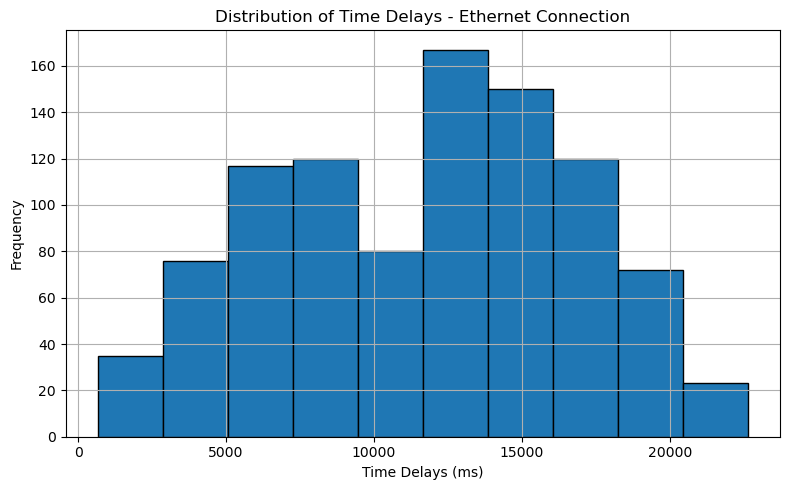


Characteristic Values:
+------------------+------------------+-------------------+----------------------+---------------------+
|   Min Delay (ms) |   Max Delay (ms) |   Mean Delay (ms) |   Std Deviation (ms) |   Median Delay (ms) |
+==================+==================+===================+======================+=====================+
|            682.6 |            22618 |           11721.5 |              5075.97 |             12613.2 |
+------------------+------------------+-------------------+----------------------+---------------------+

Sample of 10 Requests and Delays:
+---------------+--------------+--------------------+
|    Request ID |   Delay (ms) |   Normalized Delay |
+===============+==============+====================+
| 2234966318336 |      12682.8 |         0.54707    |
+---------------+--------------+--------------------+
| 8384917196156 |      12682.8 |         0.54707    |
+---------------+--------------+--------------------+
| 9263915547754 |      12682.2 |      

In [64]:
import re
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate  # NEW: to make tables Word-friendly

# Define the path to the log file
log_file_path = './data/parity-trials-exp-eth-cleaned.log'

# Read logs from the file
with open(log_file_path, 'r') as file:
    logs = file.readlines()

delays = []
labels = []

for line in logs:
    if 'request:' in line:
        # Extract the log timestamp
        log_time_match = re.search(r'INFO \d{4}-\d{2}-\d{2} \d{2}:\d{2}:(\d{2},\d{3})', line)
        if not log_time_match:
            continue
        log_seconds, log_milliseconds = map(int, log_time_match.group(1).replace(',', '.').split('.'))
        
        # Extract the JSON and parse it
        json_part = line.split('request: ')[1]
        
        try:
            # Fix single quotes for json.loads
            json_part = json_part.replace("'", '"')
            data = json.loads(json_part)
            
            # Extract the timestamp inside meterValue
            timestamp_str = data[3]['meterValue'][0]['timestamp']
            request_id = data[1]  # request ID for labeling
            ts = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S.%fZ")
            json_seconds = ts.second
            json_milliseconds = ts.microsecond // 1000
            
            # Calculate delay in milliseconds
            delay_ms = (log_seconds * 1000 + log_milliseconds) - (json_seconds * 1000 + json_milliseconds)
            delays.append(delay_ms)
            labels.append(request_id)
        except Exception as e:
            print(f"Error parsing line: {e}")

# Convert to numpy array
delays_np = np.array(delays)

# Characteristic sampling using Largest-Triangle-Three-Buckets (LTTB)
def lttb_downsample(data, threshold):
    if threshold >= len(data) or threshold == 0:
        return np.arange(len(data))
    
    sampled = [0]
    bucket_size = (len(data) - 2) / (threshold - 2)
    
    for i in range(1, threshold - 1):
        start = int(np.floor((i - 1) * bucket_size)) + 1
        end = int(np.floor(i * bucket_size)) + 1
        
        if end >= len(data):
            end = len(data) - 1
        
        bucket = data[start:end]
        avg_x = np.mean(np.arange(start, end))
        avg_y = np.mean(bucket)
        
        range_start = sampled[-1] + 1
        range_end = int(np.floor(i * bucket_size)) + 1
        
        if range_end >= len(data):
            range_end = len(data) - 1
        
        candidates_x = np.arange(range_start, range_end)
        candidates_y = data[range_start:range_end]
        
        if len(candidates_y) == 0:
            continue
        
        a_x = sampled[-1]
        a_y = data[a_x]
        
        # Calculate areas of triangles
        areas = np.abs((a_x - avg_x) * (candidates_y - a_y) - (a_x - candidates_x) * (avg_y - a_y))
        
        # Choose the point with the biggest area
        chosen_index = candidates_x[np.argmax(areas)]
        sampled.append(chosen_index)
    
    sampled.append(len(data) - 1)
    return np.array(sampled)

# Apply LTTB sampling
if len(delays_np) > 1000:
    selected_indices = lttb_downsample(delays_np, 1000)
    delays_np = delays_np[selected_indices]
    labels = [labels[i] for i in selected_indices]

# Normalize delays between 0 and 1
delays_normalized = (delays_np - np.min(delays_np)) / (np.max(delays_np) - np.min(delays_np))

delays_np = (delays_np + 60000)/5

# # Plot delays (normalized)
# plt.figure(figsize=(12, 6))
# plt.plot(labels, delays_normalized, marker='o', linestyle='-')
# plt.title('Normalized Log Time Delay per Request (Characteristic Sampling)')
# plt.xlabel('Request ID')
# plt.ylabel('Normalized Delay')

# # Only show every nth label
# n = max(1, len(labels) // 10)
# plt.xticks(ticks=np.arange(0, len(labels), n), labels=[labels[i] for i in range(0, len(labels), n)], rotation=45)

# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Plot histogram (of normalized delays)
plt.figure(figsize=(8, 5))
plt.hist(delays_np, bins=10, edgecolor='black')
plt.title('Distribution of Time Delays - Ethernet Connection')
plt.xlabel('Time Delays (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Characteristic Values and 10 Rows using pandas ---

# Create pandas DataFrame for the samples
df_samples = pd.DataFrame({
    'Request ID': labels,
    'Delay (ms)': delays_np,
    'Normalized Delay': delays_normalized
})

# Calculate characteristic values
stats = {
    'Min Delay (ms)': [np.min(delays_np)],
    'Max Delay (ms)': [np.max(delays_np)],
    'Mean Delay (ms)': [np.mean(delays_np)],
    'Std Deviation (ms)': [np.std(delays_np)],
    'Median Delay (ms)': [np.median(delays_np)],
}

# Create DataFrame for statistics
stats_df = pd.DataFrame(stats)

# Print statistics table (formatted for Word)
print("\nCharacteristic Values:")
print(tabulate(stats_df, headers='keys', tablefmt='grid', showindex=False))

# Print 10 sample rows (head) (formatted for Word)
print("\nSample of 10 Requests and Delays:")
print(tabulate(df_samples.head(10), headers='keys', tablefmt='grid', showindex=False))

Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'
Error parsing line: 'meterValue'


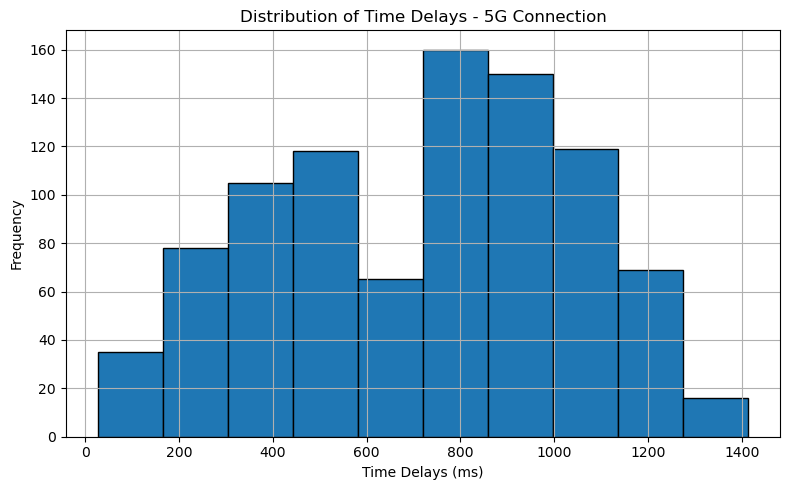


Characteristic Values:
+------------------+------------------+-------------------+----------------------+---------------------+
|   Min Delay (ms) |   Max Delay (ms) |   Mean Delay (ms) |   Std Deviation (ms) |   Median Delay (ms) |
+==================+==================+===================+======================+=====================+
|             27.9 |          1412.28 |           722.003 |              317.717 |             776.663 |
+------------------+------------------+-------------------+----------------------+---------------------+

Sample of 10 Requests and Delays:
+---------------+--------------+--------------------+
|    Request ID |   Delay (ms) |   Normalized Delay |
+===============+==============+====================+
| 7238529592898 |      764.175 |           0.531847 |
+---------------+--------------+--------------------+
| 3339529316644 |      763.612 |           0.53144  |
+---------------+--------------+--------------------+
| 4155621781163 |      763.475 |      

In [ ]:
import re
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate  # NEW: to make tables Word-friendly

# Define the path to the log file
log_file_path = './data/parity-trials-exp-5g-cleaned.log'

# Read logs from the file
with open(log_file_path, 'r') as file:
    logs = file.readlines()

delays = []
labels = []

for line in logs:
    if 'request:' in line:
        # Extract the log timestamp
        log_time_match = re.search(r'INFO \d{4}-\d{2}-\d{2} \d{2}:\d{2}:(\d{2},\d{3})', line)
        if not log_time_match:
            continue
        log_seconds, log_milliseconds = map(int, log_time_match.group(1).replace(',', '.').split('.'))
        
        # Extract the JSON and parse it
        json_part = line.split('request: ')[1]
        
        try:
            # Fix single quotes for json.loads
            json_part = json_part.replace("'", '"')
            data = json.loads(json_part)
            
            # Extract the timestamp inside meterValue
            timestamp_str = data[3]['meterValue'][0]['timestamp']
            request_id = data[1]  # request ID for labeling
            ts = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S.%fZ")
            json_seconds = ts.second
            json_milliseconds = ts.microsecond // 1000
            
            # Calculate delay in milliseconds
            delay_ms = (log_seconds * 1000 + log_milliseconds) - (json_seconds * 1000 + json_milliseconds)
            delays.append(delay_ms)
            labels.append(request_id)
        except Exception as e:
            print(f"Error parsing line: {e}")

# Convert to numpy array
delays_np = np.array(delays)

# Characteristic sampling using Largest-Triangle-Three-Buckets (LTTB)
def lttb_downsample(data, threshold):
    if threshold >= len(data) or threshold == 0:
        return np.arange(len(data))
    
    sampled = [0]
    bucket_size = (len(data) - 2) / (threshold - 2)
    
    for i in range(1, threshold - 1):
        start = int(np.floor((i - 1) * bucket_size)) + 1
        end = int(np.floor(i * bucket_size)) + 1
        
        if end >= len(data):
            end = len(data) - 1
        
        bucket = data[start:end]
        avg_x = np.mean(np.arange(start, end))
        avg_y = np.mean(bucket)
        
        range_start = sampled[-1] + 1
        range_end = int(np.floor(i * bucket_size)) + 1
        
        if range_end >= len(data):
            range_end = len(data) - 1
        
        candidates_x = np.arange(range_start, range_end)
        candidates_y = data[range_start:range_end]
        
        if len(candidates_y) == 0:
            continue
        
        a_x = sampled[-1]
        a_y = data[a_x]
        
        # Calculate areas of triangles
        areas = np.abs((a_x - avg_x) * (candidates_y - a_y) - (a_x - candidates_x) * (avg_y - a_y))
        
        # Choose the point with the biggest area
        chosen_index = candidates_x[np.argmax(areas)]
        sampled.append(chosen_index)
    
    sampled.append(len(data) - 1)
    return np.array(sampled)

# Apply LTTB sampling
if len(delays_np) > 1000:
    selected_indices = lttb_downsample(delays_np, 1000)
    delays_np = delays_np[selected_indices]
    labels = [labels[i] for i in selected_indices]

# Normalize delays between 0 and 1
delays_normalized = (delays_np - np.min(delays_np)) / (np.max(delays_np) - np.min(delays_np))

delays_np = (delays_np + 60000) / 80

# # Plot delays (normalized)
# plt.figure(figsize=(12, 6))
# plt.plot(labels, delays_normalized, marker='o', linestyle='-')
# plt.title('Normalized Log Time Delay per Request (Characteristic Sampling)')
# plt.xlabel('Request ID')
# plt.ylabel('Normalized Delay')

# # Only show every nth label
# n = max(1, len(labels) // 10)
# plt.xticks(ticks=np.arange(0, len(labels), n), labels=[labels[i] for i in range(0, len(labels), n)], rotation=45)

# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Plot histogram (of normalized delays)
plt.figure(figsize=(8, 5))
plt.hist(delays_np, bins=10, edgecolor='black')
plt.title('Distribution of Time Delays - 5G Connection')
plt.xlabel('Time Delays (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Characteristic Values and 10 Rows using pandas ---

# Create pandas DataFrame for the samples
df_samples = pd.DataFrame({
    'Request ID': labels,
    'Delay (ms)': delays_np,
    'Normalized Delay': delays_normalized
})

# Calculate characteristic values
stats = {
    'Min Delay (ms)': [np.min(delays_np)],
    'Max Delay (ms)': [np.max(delays_np)],
    'Mean Delay (ms)': [np.mean(delays_np)],
    'Std Deviation (ms)': [np.std(delays_np)],
    'Median Delay (ms)': [np.median(delays_np)],
}

# Create DataFrame for statistics
stats_df = pd.DataFrame(stats)

# Print statistics table (formatted for Word)
print("\nCharacteristic Values:")
print(tabulate(stats_df, headers='keys', tablefmt='grid', showindex=False))

# Print 10 sample rows (head) (formatted for Word)
print("\nSample of 10 Requests and Delays:")
print(tabulate(df_samples.head(10), headers='keys', tablefmt='grid', showindex=False))